In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsforecast.models import AutoARIMA
import pandas as pd
from cycler import cycler
from tqdm import trange

/home/studio-lab-user/.conda/envs/maven_forecasting/lib/python3.11/site-packages/statsforecast/core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.style.use("seaborn-v0_8-whitegrid")

In [3]:
def plot_forecast(i, step, h, forecast):
    colors = list('bgrcmy')
    plt.plot(np.arange(i * step, i * step + h), forecast['mean'], '--', color=colors[i % len(colors)])
    plt.plot(np.arange(i * step, i * step + h), forecast['lo-95'], alpha=0.5, color=colors[i % len(colors)])
    plt.plot(np.arange(i * step, i * step + h), forecast['hi-95'], alpha=0.5, color=colors[i % len(colors)])

In [22]:
np.random.seed(69)

In [23]:
# Generate some simple synthetic data
xx = np.arange(350)
yy = 0.002*xx + np.sin(2*np.pi/24*xx) + 0.2*np.random.randn(350)
anom_idx = np.random.rand(350) < 0.2
# add anomalies
yy[anom_idx] *= 3*np.random.rand(anom_idx.sum())
# plt.plot(xx, yy);
df = pd.DataFrame(yy, columns=["synthetic data"])
df.head()

,synthetic data
0,0.183101
1,0.140111
2,0.736459
3,0.819262
4,1.270009


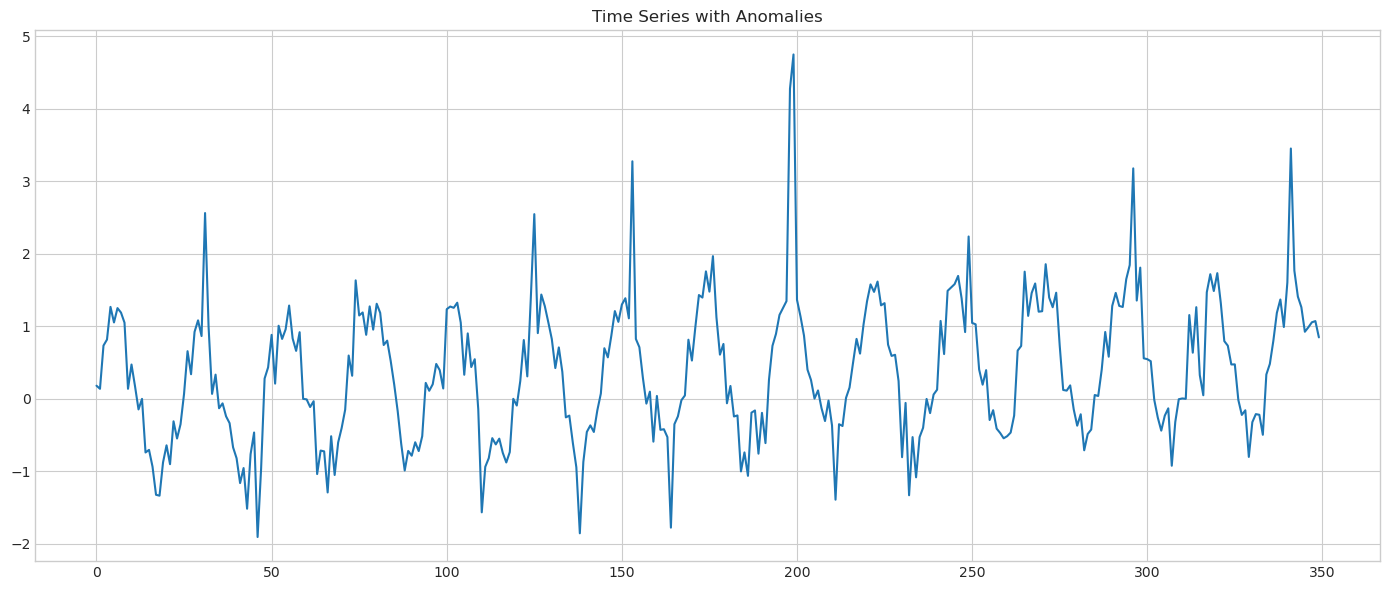

In [24]:
df.plot(legend=None, title="Time Series with Anomalies")
plt.tight_layout()

# Missing Values

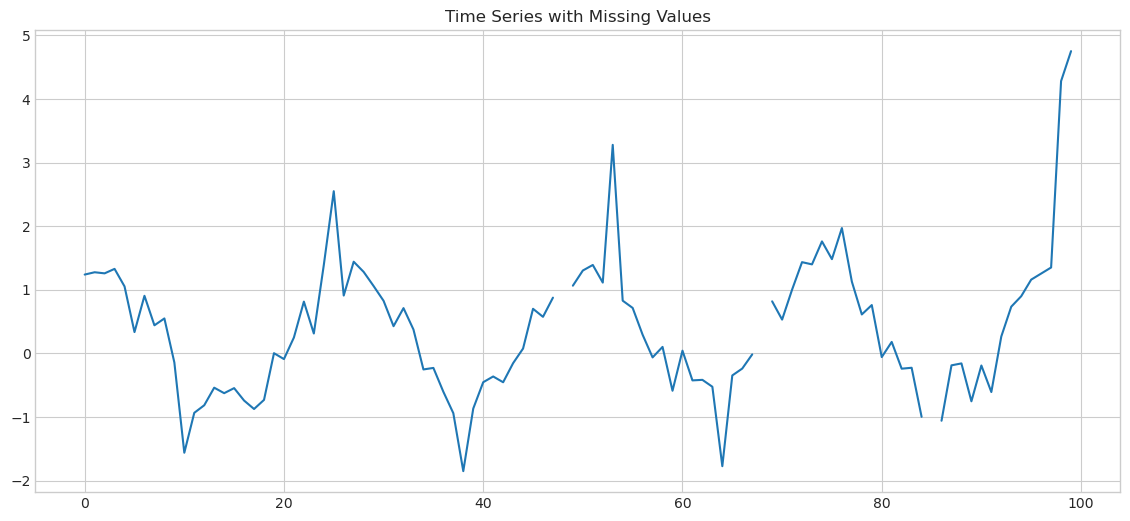

In [25]:
series_with_missing = df[100:200].copy().values.squeeze()
series_with_missing[np.random.rand(len(series_with_missing)) < 0.05] = np.nan
plt.plot(series_with_missing)
plt.title("Time Series with Missing Values");

## Arima (ignoring NaNs)
* cannot create CIs in places where training have NaN values

100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


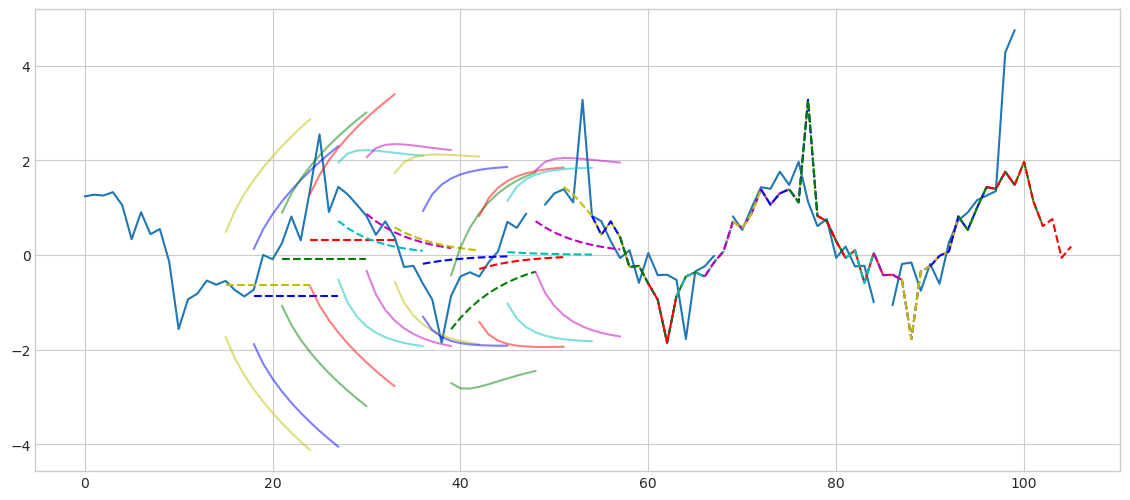

In [26]:
series = series_with_missing.copy()
step = 3
h = 10
plt.plot(series)
for i in trange(5, len(series) // step):
    train_ts = series[:i * step]
    model = AutoARIMA(season_length=24)
    model.fit(train_ts)
    forecast = model.predict(h=h, level=(95,))
    plot_forecast(i, step, h, forecast)

## Arima with missing values imputation
* solution- do a rolling forecast, and replace the missing values with samples from the predictive distribution
    * assuming first training periods (window) has no NaNs
1. calculate $\hat{\sigma}_{\varepsilon}$ (SE) using CI formula (two-tailed):
    * $\text{UB} = \bar{y} + z_{1-\frac{\alpha}{2}} \times \hat{SE}$
    * $\text{LB} = \bar{y} - z_{1-\frac{\alpha}{2}} \times \hat{SE}$
    * 
$
\begin{align}
\text{UB} - \text{LB} &= \bar{y} + z_{1-\frac{\alpha}{2}} \times \hat{SE} - \Big ( \bar{y} - z_{1-\frac{\alpha}{2}} \times \hat{SE} \Big ) \\
        &= 2\times z_{1-\frac{\alpha}{2}} +\times \hat{SE}
\end{align}
$
    * 
$
\hat{SE}_t = \frac{\text{UB}_t - \text{LB}_t}{2\times z_{1-\frac{\alpha}{2}}}
$
1. Adjust NaN value with previous window forecast (mean value) and noise (SE) for time $t$
    * $\tilde{y}_{t} = \hat{\bar{y}}_t + \hat{\varepsilon}_t$
        * $\hat{\bar{y}}_t$- predicted forecast value (mean) from previous (expanding) window
        * $\hat{\varepsilon}_t \sim N \Big ( 0, \hat{\text{SE}}^2_t \Big )$- noise


100%|██████████| 28/28 [00:25<00:00,  1.12it/s]


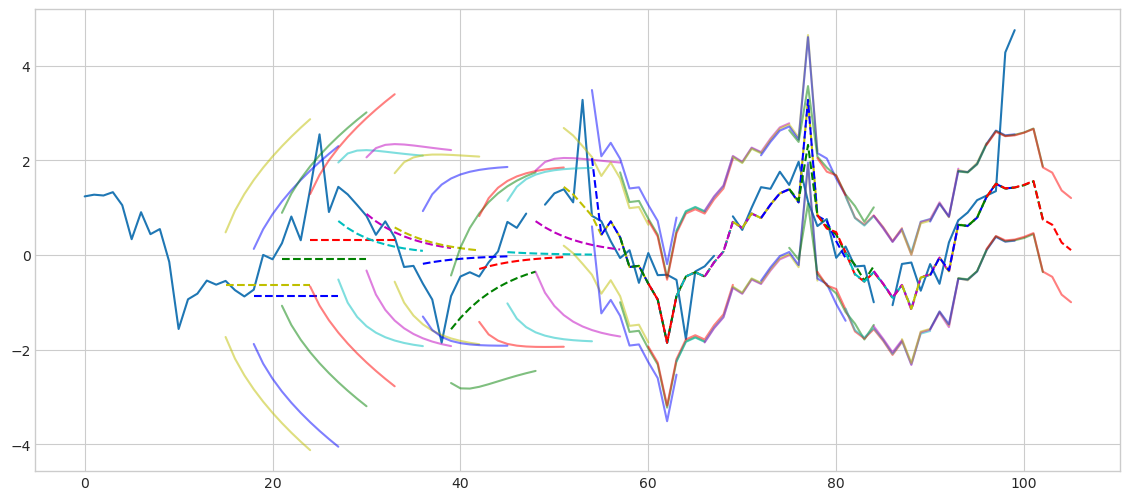

In [27]:
plt.plot(series)
previous_forecast = None
for i in trange(5, len(series) // step):
    train_ts = series[:i * step]
    if previous_forecast is not None:
        mask = np.isnan(train_ts[-step:])
        sd = (previous_forecast['hi-95'][:step].values - previous_forecast['lo-95'][:step].values) / (2 * 1.96) 
        replacements = previous_forecast['mean'][:step] + sd*np.random.randn(step)
        train_ts[-step:][mask] = replacements[mask]
    model = AutoARIMA(season_length=24)
    model.fit(train_ts)
    imputed_forecast = model.predict(h=h, level=(95,))
    previous_forecast = imputed_forecast
    plot_forecast(i, step, h, imputed_forecast)

In [28]:
results = df.loc[100:200+h].copy()
results["forecast"] = np.nan
results.loc[200 + 1: 200 + h, "forecast"] = forecast["mean"]

results["imputed forecast"] = np.nan
results.loc[200 + 1: 200 + h, "imputed forecast"] = imputed_forecast["mean"]

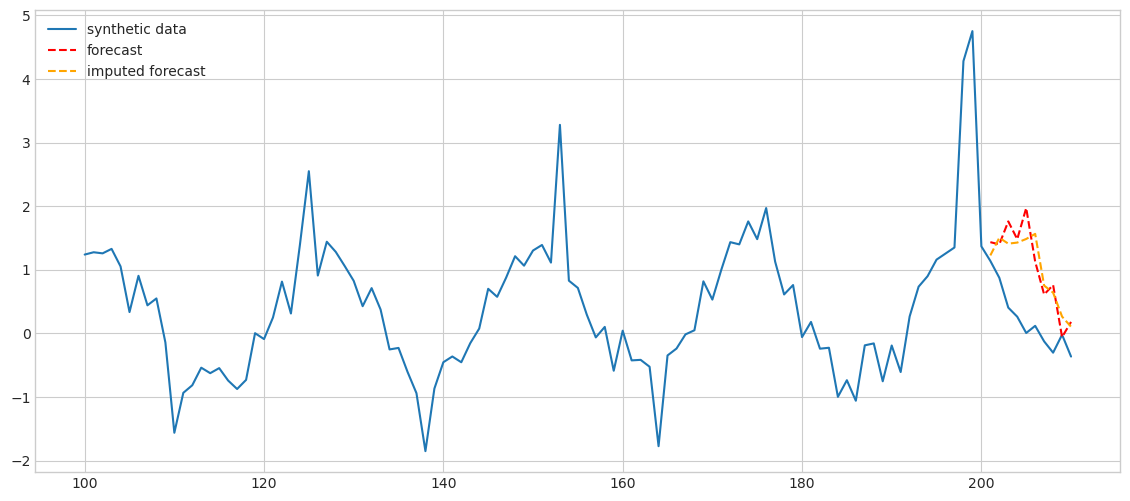

In [29]:
results["synthetic data"].plot()
results["forecast"].plot(color="red", ls="--")
results["imputed forecast"].plot(color="orange", ls="--")
plt.legend()
plt.show()

# Extreme Values
* extreme value- value is larger than CI's upper bound
    * or lower than CI's lower bound
* outlier new value- predicted forecast (mean value) from previous window + noise
    * same as missing values imputation

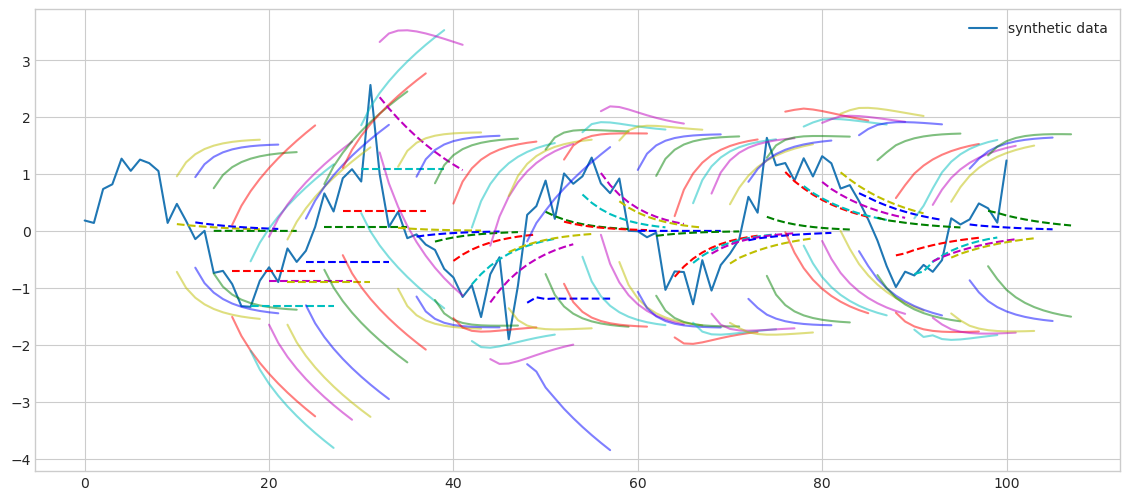

In [30]:
series = df.loc[:100]
step = 2
h = 10
series.plot()
for i in range(5, len(series) // step):
    train_ts = series[:i * step].values.squeeze()
    model = AutoARIMA()
    model.fit(train_ts)
    forecast = model.predict(h=h, level=(95,))
    plot_forecast(i, step, h, forecast)

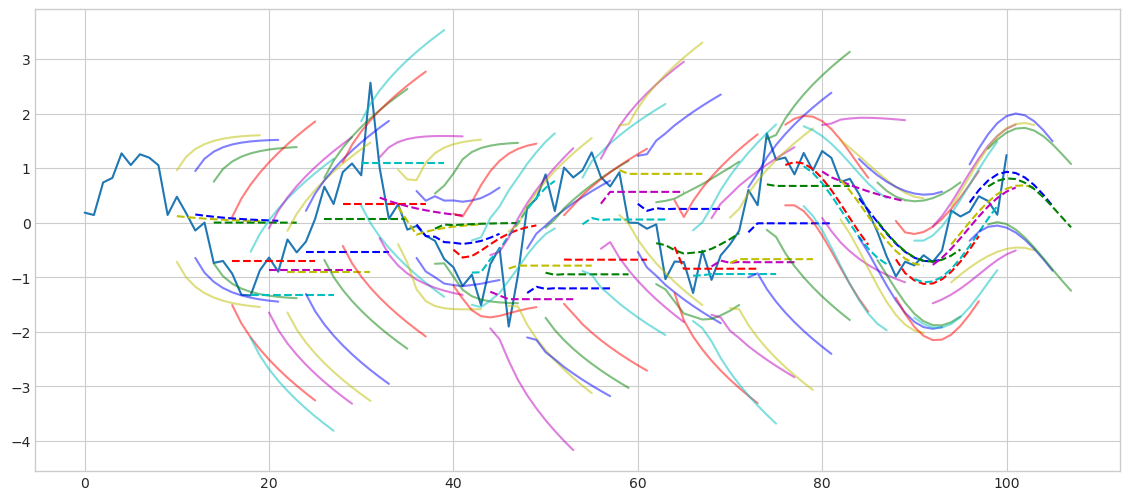

In [31]:
# step=2, h=10
series = df.loc[:100].values.copy().squeeze()
step = 2
h = 10
colors = list('bgrcmy')
plt.plot(series)
previous_forecast = None
for i in range(5, len(series) // step):
    train_ts = series[:i * step]
    if previous_forecast is not None:
        # outlier- value larger than the UB of the CI
        mask = train_ts[-step:] > previous_forecast['hi-95'][:step].values
        sd = (previous_forecast['hi-95'][:step].values - previous_forecast['lo-95'][:step].values) / (2 * 1.96) 
        replacements = previous_forecast['mean'][:step] + sd * np.random.randn(step)
        train_ts[-step:][mask] = replacements[mask]
    model = AutoARIMA()
    model.fit(train_ts)
    forecast = model.predict(h=h, level=(95,))
    previous_forecast = forecast
    plot_forecast(i, step, h, forecast)

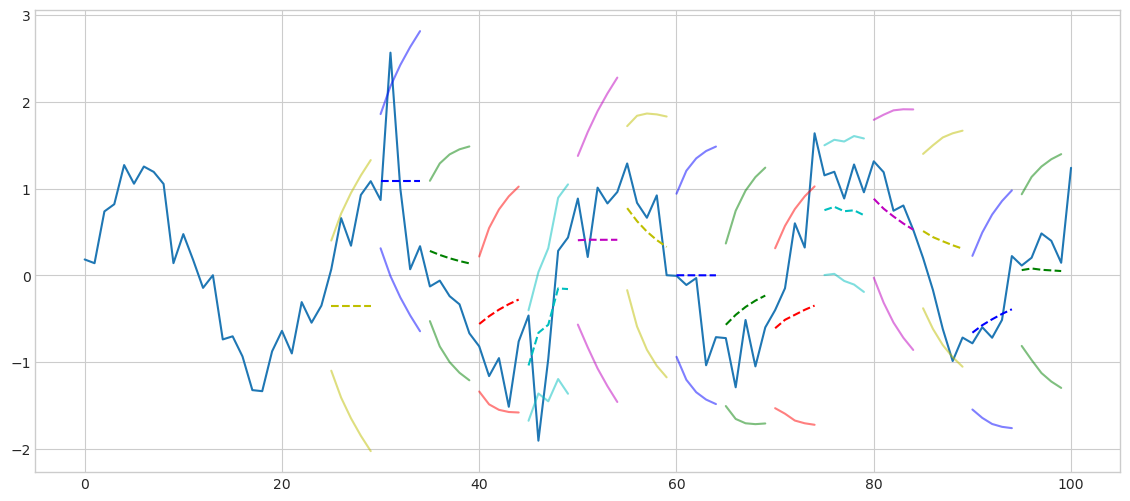

In [32]:
# step=5, h=5
series2 = df.loc[:100].values.copy().squeeze()
step = 5
h = 5
colors = list('bgrcmy')
plt.plot(series2)
previous_forecast = None
for i in range(5, len(series2) // step):
    train_ts = series2[:i * step]
    if previous_forecast is not None:
        mask = train_ts[-step:] > previous_forecast['hi-95'][:step].values
        sd = (previous_forecast['hi-95'][:step].values - previous_forecast['lo-95'][:step].values) / (2 * 1.96) 
        replacements = previous_forecast['mean'][:step] + sd * np.random.randn(step)
        train_ts[-step:][mask] = replacements[mask]
    model = AutoARIMA()
    model.fit(train_ts)
    forecast = model.predict(h=h, level=(95,))
    previous_forecast = forecast
    plot_forecast(i, step, h, forecast)

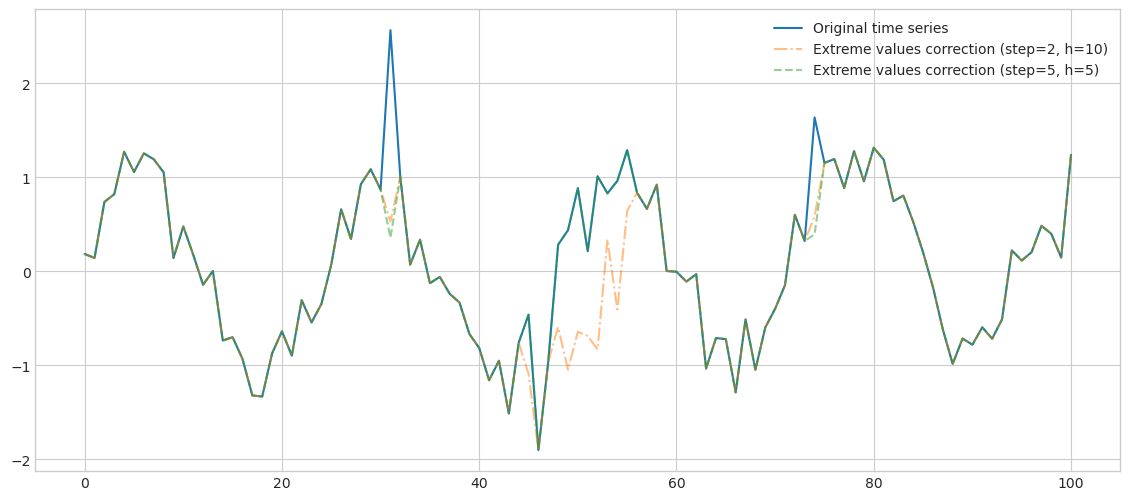

In [34]:
# '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
plt.plot(df.loc[:100].values.squeeze(), label="Original time series")
plt.plot(series, alpha=0.5, lw=1.5, ls="-.", label="Extreme values correction (step=2, h=10)")
plt.plot(series2, alpha=0.5, lw=1.5, ls="--", label="Extreme values correction (step=5, h=5)")
plt.legend()
plt.show()

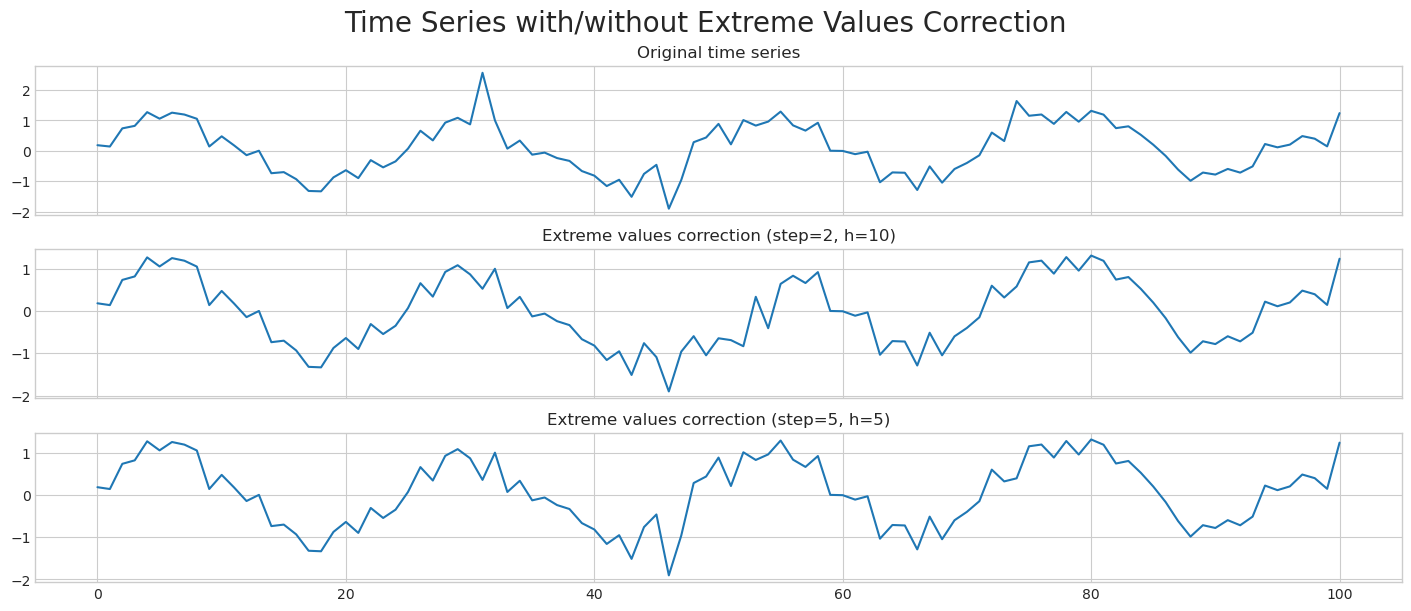

In [35]:
fig, axes = plt.subplots(3, 1, sharex=True, layout="constrained")
axes[0].plot(df.loc[:100].values)
axes[0].set( title="Original time series")
axes[1].plot(series)
axes[1].set( title="Extreme values correction (step=2, h=10)")
axes[2].plot(series2)
axes[2].set(title="Extreme values correction (step=5, h=5)")
fig.suptitle("Time Series with/without Extreme Values Correction", fontsize=20)
plt.show()